In [148]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [149]:
df=pd.read_csv('D:/Objective 1 code/classification/crop_queryTypes.csv')

In [150]:
# Split the Crop_QueryType column into a list of values
df['Crop_QueryType_List'] = df['Crop_QueryType'].str.split(',')


In [151]:
# Step 2: Create a feature matrix using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
crop_querytype_matrix = mlb.fit_transform(df['Crop_QueryType_List'])

# Convert the matrix to a DataFrame for better readability
crop_querytype_df = pd.DataFrame(crop_querytype_matrix, columns=mlb.classes_)

# Add Month and Place to the feature matrix
crop_querytype_df['Month'] = df['Month']
crop_querytype_df['Place'] = df['Place']

In [152]:
# Step 3: Split Place into State and District
crop_querytype_df['State'] = crop_querytype_df['Place'].str.split('_').str[0]
crop_querytype_df['District'] = crop_querytype_df['Place'].str.split('_').str[1]

In [153]:
# Step 4: Normalize embeddings for Place and Month with respect to mode
# Group by Place and calculate the mode of Month
mode_month_per_place = crop_querytype_df.groupby('Place')['Month'].agg(lambda x: x.mode()[0]).reset_index()
mode_month_per_place.rename(columns={'Month': 'Mode_Month'}, inplace=True)

# Merge mode_month_per_place with the main DataFrame
crop_querytype_df = pd.merge(crop_querytype_df, mode_month_per_place, on='Place')

# Normalize embeddings (standardize features)
scaler = StandardScaler()
crop_querytype_df_normalized = scaler.fit_transform(crop_querytype_df[mlb.classes_])

In [191]:
# Step 5: Cluster states based on embeddings
# Group by State and aggregate the normalized embeddings
state_embeddings = crop_querytype_df.groupby('State')[mlb.classes_].mean()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(state_embeddings)

# Step 5: Apply Spectral Clustering
# Choose the number of clusters (e.g., 5)
n_clusters = 6

from sklearn.cluster import AgglomerativeClustering

# Assuming n_clusters is defined and X_scaled is your scaled data
agglo = AgglomerativeClustering(n_clusters=n_clusters)


state_clusters =agglo.fit_predict(X_scaled)

# Add state clusters to the state_embeddings DataFrame
state_embeddings['State_Cluster'] = state_clusters

In [192]:
# Step 6: Find top 5 Crop_QueryTypes for each state
def get_top_crop_querytypes_per_state(state_embeddings, top_n=5):
    top_crop_querytypes = {}
    for state in state_embeddings.index:
        top_crops = state_embeddings.loc[state].sort_values(ascending=False).head(top_n).index.tolist()
        top_crop_querytypes[state] = top_crops
    return top_crop_querytypes

top_crop_querytypes_per_state = get_top_crop_querytypes_per_state(state_embeddings)
print(top_crop_querytypes_per_state)


{'A AND N ISLANDS': ['State_Cluster', 'Jasmine_Cultural Practices', ' Paddy Dhan_Nutrient Management', 'Sugarcane Noble Cane_Plant Protection', ' Barley Jau_Weather'], 'ANDHRA PRADESH': [' Brinjal_Plant Protection', ' Paddy Dhan_Plant Protection', ' Chillies_Plant Protection', ' BhindiOkraLadysfinger_Plant Protection', ' Paddy Dhan_Weather'], 'ARUNACHAL PRADESH': ['State_Cluster', 'Chillies_Plant Protection', ' Fresh Water_Tank Pond and Reservoir Management', 'Fresh Water_Tank Pond and Reservoir Management', ' Brinjal_Plant Protection'], 'ASSAM': ['State_Cluster', ' Fresh Water_Tank Pond and Reservoir Management', ' Chillies_Plant Protection', ' Paddy Dhan_Plant Protection', ' BovineCowBuffalo_Disease Management'], 'BIHAR': [' Brinjal_Plant Protection', ' Mango_Plant Protection', ' BovineCowBuffalo_Disease Management', ' BhindiOkraLadysfinger_Plant Protection', ' Bottle Gourd _Plant Protection'], 'CHHATTISGARH': ['State_Cluster', ' Paddy Dhan_Plant Protection', ' Brinjal_Plant Protecti

In [193]:
# Step 7: Find top 10 Crop_QueryTypes for each state cluster
def get_top_crop_querytypes_per_cluster(state_embeddings, top_n=10):
    top_crop_querytypes = {}
    for cluster in state_embeddings['State_Cluster'].unique():
        cluster_subset = state_embeddings[state_embeddings['State_Cluster'] == cluster]
        top_crops = cluster_subset.drop(columns='State_Cluster').mean().sort_values(ascending=False).head(top_n).index.tolist()
        top_crop_querytypes[cluster] = top_crops
    return top_crop_querytypes

top_crop_querytypes_per_cluster = get_top_crop_querytypes_per_cluster(state_embeddings)
print(top_crop_querytypes_per_cluster)

{1: [' Paddy Dhan_Plant Protection', ' Chillies_Plant Protection', ' Brinjal_Plant Protection', ' Tomato_Plant Protection', ' BhindiOkraLadysfinger_Plant Protection', ' Mango_Plant Protection', ' Paddy Dhan_Cultural Practices', ' Paddy Dhan_Weather', ' Paddy Dhan_Nutrient Management', ' Paddy Dhan_Fertilizer Use and Availability'], 0: [' Brinjal_Plant Protection', ' Chillies_Plant Protection', ' Tomato_Plant Protection', ' Mango_Plant Protection', ' BhindiOkraLadysfinger_Plant Protection', ' Paddy Dhan_Plant Protection', ' Paddy Dhan_Weather', ' Onion_Plant Protection', ' Bottle Gourd _Plant Protection', ' Bitter Gourd_Plant Protection'], 2: [' Wheat_Weather', ' Tomato_Plant Protection', ' Brinjal_Plant Protection', ' BovineCowBuffalo_Disease Management', ' Chillies_Plant Protection', ' Bottle Gourd _Plant Protection', ' Mango_Plant Protection', ' Wheat_Plant Protection', ' Sugarcane Noble Cane_Plant Protection', ' Paddy Dhan_Weather'], 4: [' Brinjal_Plant Protection', ' Chillies_Plant

In [194]:
top_crop_querytypes_per_state_df = pd.DataFrame(list(top_crop_querytypes_per_state.items()), columns=['State', 'Top_5_Crop_QueryTypes'])
top_crop_querytypes_per_state_df.to_csv('D:\Objective 1 code\clusteringtop_crop_querytypes_per_state.csv', index=False)

# Save top 10 Crop_QueryTypes per cluster
top_crop_querytypes_per_cluster_df = pd.DataFrame(list(top_crop_querytypes_per_cluster.items()), columns=['State_Cluster', 'Top_10_Crop_QueryTypes'])
top_crop_querytypes_per_cluster_df.to_csv('D:\Objective 1 code\clusteringtop_crop_querytypes_per_cluster.csv', index=False)


<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Admin\AppData\Local\Temp\ipykernel_16936\1346104313.py:2: SyntaxWarning: invalid escape sequence '\O'
  top_crop_querytypes_per_state_df.to_csv('D:\Objective 1 code\clusteringtop_crop_querytypes_per_state.csv', index=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16936\1346104313.py:6: SyntaxWarning: invalid escape sequence '\O'
  top_crop_querytypes_per_cluster_df.to_csv('D:\Objective 1 code\clusteringtop_crop_querytypes_per_cluster.csv', index=False)


In [201]:
# Add state clusters to the state_embeddings DataFrame
state_embeddings['State_Cluster'] = state_clusters

# Step 6: Assign each place to its corresponding state cluster
# Create a mapping of State to State_Cluster
state_to_cluster = state_embeddings['State_Cluster'].to_dict()

# Add State_Cluster to the main DataFrame
crop_querytype_df['State_Cluster'] = crop_querytype_df['State'].map(state_to_cluster)

# Step 7: Save the place-cluster mapping to a CSV file
place_clusters = crop_querytype_df[['Place', 'State_Cluster']].drop_duplicates()
place_clusters.to_csv('D:\Objective 1 code\place_clusters.csv', index=False)
print(place_clusters)


                                Place  State_Cluster
0             A AND N ISLANDS_NICOBAR              1
1             ANDHRA PRADESH_ANANTPUR              0
2             ANDHRA PRADESH_CHITTOOR              0
3        ANDHRA PRADESH_EAST GODAVARI              0
4               ANDHRA PRADESH_GUNTUR              0
...                               ...            ...
4891                    MIZORAM_SAIHA              1
4892                MIZORAM_SERCCHIP               1
6184     MEGHALAYA_WEST JAINTIA HILLS              1
7469  MEGHALAYA_SOUTH WEST GARO HILLS              1
7473                    MIZORAM_MAMIT              1

[677 rows x 2 columns]


<>:13: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\O'
C:\Users\Admin\AppData\Local\Temp\ipykernel_16936\2102215597.py:13: SyntaxWarning: invalid escape sequence '\O'
  place_clusters.to_csv('D:\Objective 1 code\place_clusters.csv', index=False)


In [198]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Step 1: Extract features and cluster labels
X = place_features  # Feature matrix (without Place and Month)
labels = place_month_features['Cluster']  # Cluster labels

# Step 2: Calculate evaluation metrics
# Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")



Silhouette Score: 0.16907679696602929
Calinski-Harabasz Index: 156.5307059050132
Davies-Bouldin Index: 3.7254349973795877


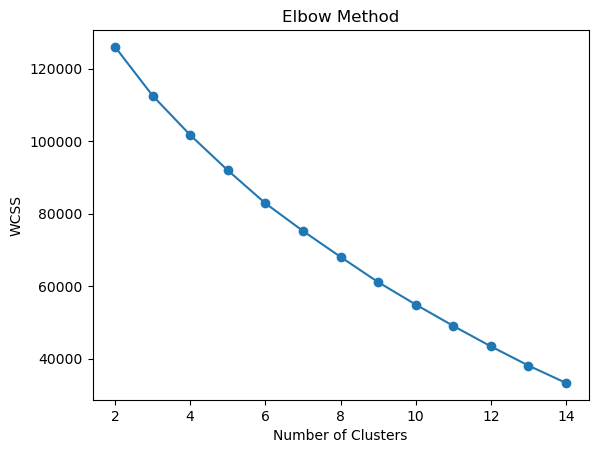

Optimal number of clusters: 6


In [199]:
from kneed import KneeLocator 
wcss = []
n_clusters_range = range(2, 15)

for n in n_clusters_range:
    # Fit AgglomerativeClustering
    agglo = AgglomerativeClustering(n_clusters=n)
    agglo.fit(X_scaled)
    
    # Calculate WCSS manually
    cluster_labels = agglo.labels_  # Get cluster labels for each data point
    wcss_n = 0  # Initialize WCSS for this number of clusters
    
    # Compute the sum of squared distances for each cluster
    for i in range(n):
        cluster_points = X_scaled[cluster_labels == i]  # Points in the cluster
        cluster_center = np.mean(cluster_points, axis=0)  # Cluster centroid
        wcss_n += np.sum((cluster_points - cluster_center) ** 2)  # Sum of squared distances
    
    wcss.append(wcss_n) # Inertia is the WCSS

plt.plot(n_clusters_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()
# Automatically find the elbow point using the KneeLocator
knee = KneeLocator(n_clusters_range, wcss, curve='convex', direction='decreasing')
optimal_clusters = knee.elbow

print(f"Optimal number of clusters: {optimal_clusters}")